## PART 5 - STOCK PRICE PREDICTION USING WORD EMBEDDINGS 

The below model consists of the following steps:

- Step 1 - Data Collection 
- Step 2 - Formatting 'Date' from news headlines to match with 'Date' from numerical stock data
- Step 3 - Merging the two datasets on unique dates from stock data
- Step 4 - Cleaning the text to remove unwanted characters, contradictions, stopwords etc
- Step 5 - Creating a Dictionary for each unique word and it's counts 
- Step 6 - Creating a Dictionary for each word in Glove embedding and it's embedding representation
- Step 7 - Creating a Dictionary to convert words to integers
- Step 8 - Creating a reverse mapping Dictionary to convert integer representations to their words 
- Step 9 - Creating a word embedding matrix for each unique word in the dataset and its embedding representation 
- Step 10 - Create integer representation of all the news headlines 
- Step 11 - Normalize the data
- Step 12 - Train multi-modal Bi directinal LSTM engine  
- Step 13 - Test and Evaluate multi-modal Bi directional LSTM engine 

### Results -  The predictive model was applied on news and numerical data of the following stocks and analyzed

    1. Apple



In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt
from datetime import datetime, date

/Users/aishwaryagunashekar/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [3]:
stock_data = pd.read_csv("/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/AAPL_indicators.csv")
news_headlines = pd.read_csv("/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/scraped_news_apple.csv")
(stock_data.head())

,Date,Close,Volume,MA7,MA21,MA42,MACD,EMA
0,2013-01-02,78.432854,140129500,74.660203,76.123333,78.372075,0.000000,78.432854
1,2013-01-03,77.442856,88241300,75.124897,75.823401,78.186905,-0.022211,77.690356
2,2013-01-04,75.285713,148583400,75.264284,75.491088,78.017517,-0.095195,76.025603
3,2013-01-07,74.842857,121039100,75.486734,75.389795,77.810986,-0.142045,75.227249
4,2013-01-08,75.044289,114676800,75.695917,75.240612,77.615272,-0.156497,75.104772


In [4]:
#Deleting all the rows of year 2012 - 2017
stock_dataset = stock_data.drop(stock_data.index[:1259]).copy()
stock_dataset.head(5)

,Date,Close,Volume,MA7,MA21,MA42,MACD,EMA
1259,2018-01-02,172.259995,25555900,171.965714,171.909047,172.157619,0.386977,171.455446
1260,2018-01-03,172.229996,29517900,171.568571,171.965238,172.284762,0.375116,171.971813
1261,2018-01-04,173.029999,22434600,171.285714,172.119047,172.401905,0.425366,172.677270
1262,2018-01-05,175.000000,23660000,171.918571,172.374285,172.461429,0.617039,174.225757
1263,2018-01-08,174.350006,20567800,172.454285,172.628571,172.463810,0.708328,174.308590


In [5]:
# Get rid of , in the Volume, then convert it to a float
def volume_to_float(volume_str):
    volume_str = str(volume_str)
    return float(volume_str.replace(",",""))

stock_dataset['Volume'] = stock_dataset['Volume'].apply(volume_to_float)

In [6]:
(news_headlines.head())

,Article_Title,Published_date
0,"Apple fixes FaceTime privacy bug, will issue u...",Feb 01 2019
1,UPDATE 2-Foxconn vows to build Wisconsin plant...,Feb 01 2019
2,Breakingviews - Review: The case for regulatin...,Feb 01 2019
3,"UPDATE 1-Apple fixes FaceTime privacy bug, wil...",Feb 01 2019
4,"Venezuela's Maduro loosens private sector, cur...",Jan 31 2019


#### FORMATTING DATE TO REQUIRED FORMAT OF STOCK DATA 

We see that there is a discrepancy in the way the date is represented in the Stock data and the how the date is scraped from the news websites. This should be fixed in order to combine the stock data with the news data. 

In [ ]:
#Fixing the format of the date

date_list = []
for date in news_headlines['Published_date']:
    datetime_object = datetime.strptime(date + '  1:33PM', '%b %d %Y %I:%M%p')
    if(datetime_object.month < 10):
        month = "0" + str(datetime_object.month)
    else:
        month = str(datetime_object.month)
    if(datetime_object.day < 10):
        day = "0" + str(datetime_object.day)
    else:
        day = str(datetime_object.day)
    date_list.append(str(datetime_object.year) + "-" + month + "-" + day)
    print(str(datetime_object.year) + "-" + month + "-" + day)

In [8]:
#Converted Date and Reindexing

news_headlines['Date'] = np.array(date_list)
news_headlines = news_headlines.reindex(index=news_headlines.index[::-1]).copy()
print(news_headlines.head())

                                         Article_Title Published_date  \
799           MIDEAST - Factors to watch - December 31    Dec 30 2017   
798  Breakingviews - TV content wars will have gris...    Jan 02 2018   
797  Breakingviews - Tech salad will come with a si...    Jan 03 2018   
796  SEC mixes message on Apple shareholder proposa...    Jan 03 2018   
795  SEC mixes message on Apple shareholder proposa...    Jan 03 2018   

           Date  
799  2017-12-30  
798  2018-01-02  
797  2018-01-03  
796  2018-01-03  
795  2018-01-03  


#### Ensure the Dates from both the datasets are indexed in the same order ( Jan 2018 to Dec 2018 ). 
#### If this is not in the same order, when we try to retain only the news headlines for the financial days later on, we will face major issues.


In [9]:
print(stock_dataset.head(3))

            Date       Close      Volume         MA7        MA21        MA42  \
1259  2018-01-02  172.259995  25555900.0  171.965714  171.909047  172.157619   
1260  2018-01-03  172.229996  29517900.0  171.568571  171.965238  172.284762   
1261  2018-01-04  173.029999  22434600.0  171.285714  172.119047  172.401905   

          MACD         EMA  
1259  0.386977  171.455446  
1260  0.375116  171.971813  
1261  0.425366  172.677270  


In [10]:
# Checking for null values
news_headlines.isnull().sum()

Article_Title     0
Published_date    0
Date              0
dtype: int64

In [11]:
news_headlines.drop(['Published_date'], inplace = True, axis=1)
print(stock_data.shape)
print(news_headlines.shape)


(1510, 8)
(800, 2)


#### We extract the news for all the dates the stock market is active, i.e only for the financial days. 


In [12]:
print(len(set(stock_dataset.Date)))
print(len(set(news_headlines.Date)))

251
249


#### Remove the extra dates that are in news. We loop throough all the dates in news headlines, now that we have taken care of the format, we retain only those that are present in the stock dataset

In [13]:
news_headlines = news_headlines[news_headlines.Date.isin(stock_dataset.Date)]

In [14]:
missing_dates = list(set(stock_dataset.Date) - set(news_headlines.Date))
len(missing_dates)

49

In [111]:
#Merging the two datasets over the 'Date' column, performing a LEFT JOIN 
merged_data = pd.merge(stock_dataset, news_headlines, on='Date', how='left')
merged_data['Article_Title'].fillna("", inplace=True)

merged_data.head(10)

,Date,Close,Volume,MA7,MA21,MA42,MACD,EMA,Article_Title
0,2018-01-02,172.259995,25555900.0,171.965714,171.909047,172.157619,0.386977,171.455446,Breakingviews - TV content wars will have gris...
1,2018-01-03,172.229996,29517900.0,171.568571,171.965238,172.284762,0.375116,171.971813,Breakingviews - Tech salad will come with a si...
2,2018-01-03,172.229996,29517900.0,171.568571,171.965238,172.284762,0.375116,171.971813,SEC mixes message on Apple shareholder proposa...
3,2018-01-03,172.229996,29517900.0,171.568571,171.965238,172.284762,0.375116,171.971813,SEC mixes message on Apple shareholder proposa...
4,2018-01-04,173.029999,22434600.0,171.285714,172.119047,172.401905,0.425366,172.677270,
5,2018-01-05,175.000000,23660000.0,171.918571,172.374285,172.461429,0.617039,174.225757,"UPDATE 2-Apple to issue fix for iPhones, Macs ..."
6,2018-01-05,175.000000,23660000.0,171.918571,172.374285,172.461429,0.617039,174.225757,"Apple to issue fix for iPhones, Macs at risk f..."
7,2018-01-05,175.000000,23660000.0,171.918571,172.374285,172.461429,0.617039,174.225757,Friday Morning Briefing
8,2018-01-08,174.350006,20567800.0,172.454285,172.628571,172.463810,0.708328,174.308590,Monday Morning Briefing
9,2018-01-08,174.350006,20567800.0,172.454285,172.628571,172.463810,0.708328,174.308590,REFILE-Apple should address youth phone addict...


In [16]:
#Removing the extra headlines for the same dates, simplifies our dataset 
merged_data = merged_data.drop_duplicates(subset=['Date'], keep='first')

In [ ]:
# Create a list of the opening prices and their corresponding daily headlines from the news
price = []
newstitles = []

for row in merged_data.iterrows():
    date = row[1]['Date']
    print(date)
    price.append(row[1]['Close'])
    newstitles.append(row[1]['Article_Title'])    
    # Track progress
    if len(price) % 20 == 0:
        print(len(price))

In [18]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [1]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'us ', ' united states ', text)
    text = re.sub(r'u.s. ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u.n. ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'uk ', ' united kingdom ', text)
    #text = re.sub(r'$ ', 'dollar  ', text)
    #text = re.sub(r'$', 'dollar  ', text)
    text = re.sub(r' yr ', ' year ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [ ]:
# Clean the headlines
clean_headlines = []

for daily_headlines in merged_data["Article_Title"]:
    print(daily_headlines)
    clean_headlines.append(clean_text(daily_headlines))

In [22]:
# Store each unique word and it's counts 
word_counts = {}

for line in clean_headlines:
    for word in line.split():
        if word not in word_counts:
            word_counts[word] = 1
        else:
            word_counts[word] += 1
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 1015


In [23]:
# Load GloVe's embeddings
embeddings_index = {}
with open('/Users/aishwaryagunashekar/Desktop/Stock_Market_Project/Data/glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        
        #Get the word represented 
        word = values[0]
        
        #Get the corresponding vector representation of the word 
        embedding = np.asarray(values[1:], dtype='float32')
        
        #Store every word and it's corresponding representation in a dictionary 
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 2196017


In [24]:
# Find the number of words that are missing from GloVe, and are used more than our threshold.
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from GloVe:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from GloVe: 1
Percent of words that are missing from vocabulary: 0.1%


In [27]:
# Limit the vocab to words that appear are in GloVe

# Dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

codes = ["<UNK>","<PAD>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word



In [30]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 300

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim))

#At the location i(int rep of the word) in the word_embedding_matrix, the corresponding Glove representation will b stored
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        # Row i in the matrix will be filled with the Glove vector representation of the corresponding word 
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

835


In [ ]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

int_headlines = []

for date in clean_headlines:
    int_headline = []
    print(date)
    for word in date.split():
        
        word_count += 1 
        if word in vocab_to_int:
            int_headline.append(vocab_to_int[word])
            print(word, vocab_to_int[word])
        else:
            int_headline.append(vocab_to_int["<UNK>"])
            print(word, vocab_to_int["<UNK>"])
            unk_count += 1
        
    print("\nWords being appended as a sentence\n", date)
    print(int_headline)
    int_headlines.append(int_headline)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

In [ ]:
# Find the length of headlines
lengths = []
for date in int_headlines:
    print(date)
    print("\n")
    lengths.append(len(date))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [33]:
lengths.describe()

,counts
count,251.000000
mean,7.199203
std,3.654061
min,1.000000
25%,6.000000
50%,8.000000
75%,10.000000
max,16.000000


In [35]:
# Limit the length of a day's news to 15 words

max_headline_length = 15
pad_final_headlines = []

for headline in int_headlines:
    pad_headlines = []
    # Add padding if headline is less than max length
    if len(headline) <= max_headline_length:
        for word in headline:
            pad_headlines.append(word)
        for i in range(max_headline_length-len(pad_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_headlines.append(pad)
        pad_final_headlines.append(pad_headlines)
    # Limit headline if it is more than max length  
    else:
        headline = headline[:max_headline_length]
        pad_final_headlines.append(headline)
pad_final_headlines

[[833, 421, 572, 35, 425, 662, 833, 834, 834, 834, 834, 834, 834, 834, 834],
 [833, 488, 225, 215, 79, 725, 833, 834, 834, 834, 834, 834, 834, 834, 834],
 [609, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834],
 [751, 423, 511, 108, 541, 480, 582, 759, 750, 412, 833, 834, 834, 834, 834],
 [622, 706, 833, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834],
 [441, 706, 833, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834],
 .
 .
 .
 [609, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834, 834]]

In [ ]:
# Find the length of headlines
lengths = []
for date in pad_final_headlines:
    print(date)
    print("\n")
    lengths.append(len(date))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [37]:
lengths.describe()

,counts
count,251.0
mean,15.0
std,0.0
min,15.0
25%,15.0
50%,15.0
75%,15.0
max,15.0


In [38]:
import tensorflow as tf
import keras
print(tf.__version__) #1.3.0
print(keras.__version__) #2.2.0

Using TensorFlow backend.


1.5.1
2.2.2


In [39]:
from keras.models import Sequential
from keras import initializers
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, Concatenate, Bidirectional
from keras.layers.merge import concatenate, add
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

In [40]:
merged_data.head(1)

,Date,Close,Volume,MA7,MA21,MA42,MACD,EMA,Article_Title
0,2018-01-02,172.259995,25555900.0,171.965714,171.909047,172.157619,0.386977,171.455446,Breakingviews - TV content wars will have gris...


In [43]:
# 1,6 refers to  the 2nd and 7th column with column indices(1 - OPEN, 6 - VOLUME )
training_set = merged_data.iloc[:, [1,2,3,4,5,6,7]].values
training_set_close = merged_data.iloc[:, [1]].values

In [45]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
sc_close = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_close_scaled = sc_close.fit_transform(training_set_close)
print(np.shape(training_set_scaled))
print(np.shape(training_set_close_scaled))

(251, 7)
(251, 1)


In [46]:
scaled_df = pd.DataFrame(training_set_scaled)
scaled_df.head(2)

,0,1,2,3,4,5,6
0,0.298334,0.155757,0.239419,0.107845,0.032594,0.630968,0.274252
1,0.297982,0.203075,0.233967,0.108817,0.035051,0.630313,0.280563


In [47]:
# Split data into training and testing sets.
# Validating data will be created during training.
x_train, x_test, y_train, y_test = train_test_split(pad_final_headlines, scaled_df[[0]], test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [55]:
x_train.shape

(213, 15)

In [54]:
x_test.shape

(38, 15)

In [56]:
merged_data[['Close', 'Volume', 'MA7', 'MA21', 'MA42', 'MACD', 'EMA']].head(1)

,Close,Volume,MA7,MA21,MA42,MACD,EMA
0,172.259995,25555900.0,171.965714,171.909047,172.157619,0.386977,171.455446


In [78]:
# Split data into training and testing sets.
# Validating data will be created during training.
close_train, close_test, closey_train, closey_test = train_test_split(scaled_df[[1,2,3,4,5,6]], scaled_df[[0]], test_size = 0.15, random_state = 2)

close_train = np.array(close_train)
close_test = np.array(close_test)
closey_train = np.array(closey_train)
closey_test = np.array(closey_test)

In [79]:
close_test.shape

(38, 6)

In [81]:
closey_test.shape

(38, 1)

### MULTI MODAL RECURRENT NEURAL NETWORK FOR COMBINED TEXT AND NUMERICAL INPUTS

In [62]:
#Multi-Modal Recurrent Neural Network Architecture 

#Creating an input layer for the textual news headlines 
nlp_input = Input(shape=(max_headline_length,), name='nlp_input')

#Creating an Input layer for the continuous numerical stock data 
meta_input = Input(shape=(6,), name='meta_input')

#Creating an embedding layer to map the headlines to their respective word embedding vectors 
emb = Embedding(output_dim=embedding_dim, input_dim=nb_words, weights=[word_embedding_matrix], input_length=max_headline_length)(nlp_input)

#Using the Embedding layer as an input to the Bidirectional LSTM layer with Close prices as Target 
news_out = Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)

#Concatenating the output of the Embedding layer with the numerical stock data layer 
x = concatenate([news_out, meta_input])

#Using the combined layer as Input to a Dense Neural Network Layer 
x = Dense(32, kernel_initializer="uniform",activation='relu')(x)

#Feeding it into the Dense output layer with one output 
x = Dense(units = 1)(x)

#Defining the model 
model = Model(inputs=[nlp_input , meta_input], outputs=[x])

In [63]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [96]:
model.fit( [x_train, close_train], y_train, epochs = 10, batch_size = 64)
model.summary()

Epoch 1/10
213/213 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 2/10
213/213 [==============================] - 1s 3ms/step - loss: 9.2689e-04
Epoch 3/10
213/213 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 4/10
213/213 [==============================] - 1s 3ms/step - loss: 9.9491e-04
Epoch 5/10
213/213 [==============================] - 1s 3ms/step - loss: 0.0010
Epoch 6/10
213/213 [==============================] - 1s 2ms/step - loss: 0.0010
Epoch 7/10
213/213 [==============================] - 1s 3ms/step - loss: 9.2028e-04
Epoch 8/10
213/213 [==============================] - 1s 3ms/step - loss: 9.8538e-04
Epoch 9/10
213/213 [==============================] - 1s 2ms/step - loss: 9.2577e-04
Epoch 10/10
213/213 [==============================] - 1s 3ms/step - loss: 0.0010
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Conne

In [101]:
predicted_stock_price = model.predict([x_test, close_test])

In [102]:
predicted_stock_price = sc_close.inverse_transform(predicted_stock_price)
real_stock_price = sc_close.inverse_transform(closey_test)

In [103]:
percentile_list = pd.DataFrame(np.column_stack([real_stock_price, predicted_stock_price]), 
                               columns=['real_stock_price', 'predicted_stock_price'])
percentile_list

,real_stock_price,predicted_stock_price
0,190.039993,185.607117
1,188.149994,189.079636
2,188.179993,189.561615
3,176.779999,182.138123
4,183.919998,187.783142
5,166.070007,165.534134
6,192.229996,197.078186
7,167.369995,164.645737
8,172.500000,169.960007
9,191.610001,194.793564


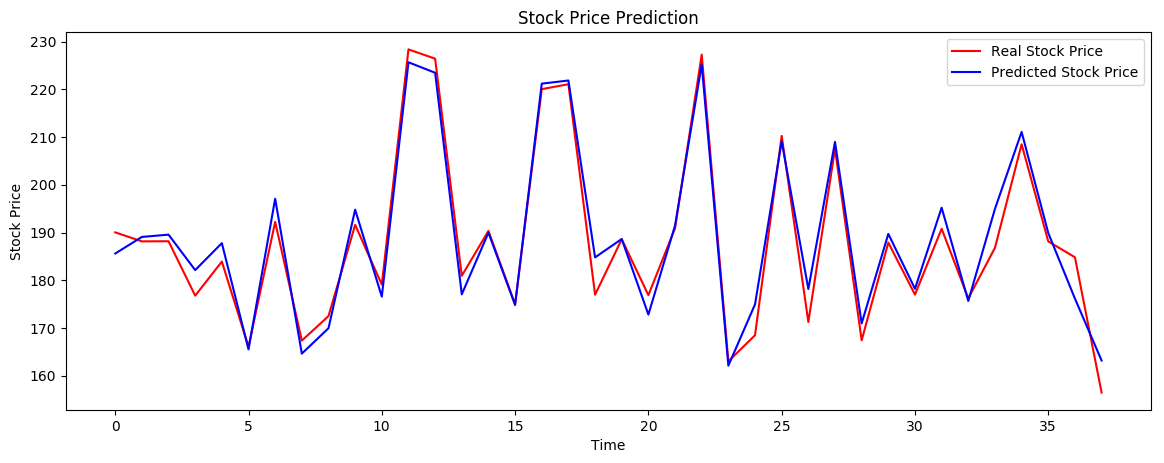

In [104]:
# Visualising the results
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [107]:
direction_pred = []
for pred in predicted_stock_price:
    #print(pred)
    if np.around(pred,1) >= np.around(np.mean(real_stock_price),1):
        direction_pred.append(1)
    else:
        direction_pred.append(0)

direction_test = []
for value in real_stock_price:
    #print(value)
    if np.around(value, 1) >= np.around(np.mean(real_stock_price), 1):
        direction_test.append(1)
    else:
        direction_test.append(0)

In [108]:
print("Predicted Direction", direction_pred)
print("Actual Direction", direction_test)

Predicted Direction [0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0]
Actual Direction [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0]


In [110]:
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))


Predicted values matched the actual direction 92.11% of the time.
